<a href="https://colab.research.google.com/github/parvezmosaraf/Machine-Learning-Project/blob/main/Electricity_forecast_Load%20using%20LSTM-GRU%20with%20pso%20optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import nltk
import gc
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
pip install pyswarms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 104 kB 5.2 MB/s 


In [3]:
df=pd.read_csv('/content/drive/MyDrive/GefCom2017/Gefcom 2017.csv')
df.head()


,Unnamed: 0,ts,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday_name,holiday,trend
0,1,NaN,CT,3386.0,25.0,19.0,3/1/2003,2003,Mar,1,Sat,60,True,NaN,False,0.0
1,2,3/1/2003 1:00,CT,3258.0,23.0,18.0,3/1/2003,2003,Mar,2,Sat,60,True,NaN,False,1.0
2,3,3/1/2003 2:00,CT,3189.0,22.0,18.0,3/1/2003,2003,Mar,3,Sat,60,True,NaN,False,2.0
3,4,3/1/2003 3:00,CT,3157.0,22.0,19.0,3/1/2003,2003,Mar,4,Sat,60,True,NaN,False,3.0
4,5,3/1/2003 4:00,CT,3166.0,23.0,19.0,3/1/2003,2003,Mar,5,Sat,60,True,NaN,False,4.0


In [4]:
df = df.drop('zone', axis=1)

In [5]:
df = df.drop(['month'], axis = 1)

In [6]:
df = df.drop(['day_of_week'], axis = 1)

In [7]:
df = df.drop(['weekend'], axis = 1)

In [8]:
df = df.drop(['holiday_name'], axis = 1)

In [9]:
df = df.drop(['holiday'], axis = 1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Unnamed: 0   1048575 non-null  int64  
 1   ts           1048574 non-null  object 
 2   demand       1048575 non-null  float64
 3   drybulb      1048575 non-null  float64
 4   dewpnt       1048575 non-null  float64
 5   date         1048575 non-null  object 
 6   year         1048575 non-null  int64  
 7   hour         1048575 non-null  int64  
 8   day_of_year  1048575 non-null  int64  
 9   trend        1048575 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 80.0+ MB


In [11]:
df['date']=pd.to_datetime(df['date'])

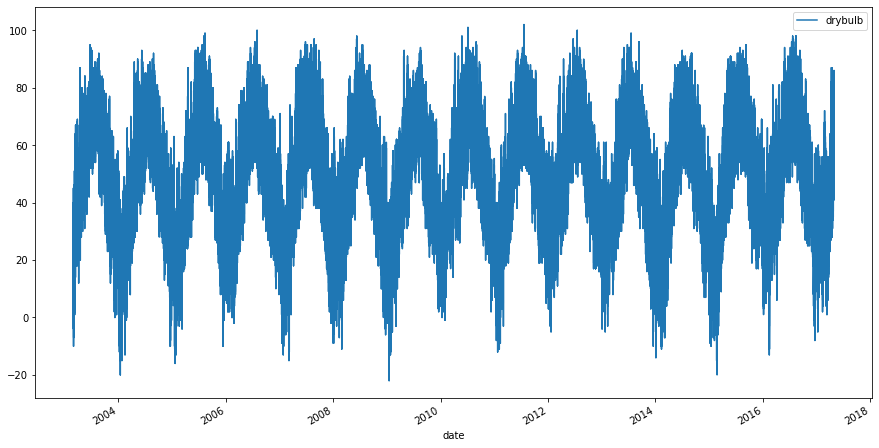

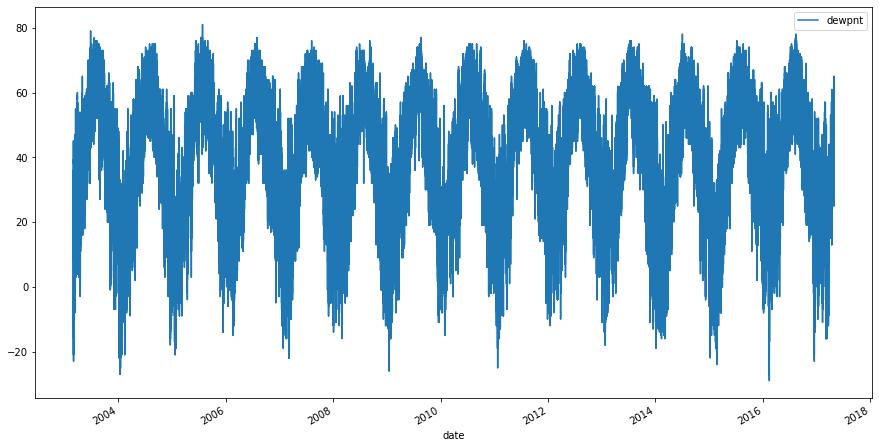

In [12]:
df.plot(x='date',y='drybulb',figsize=(15,8))

df.plot(x='date',y='dewpnt',figsize=(15,8))

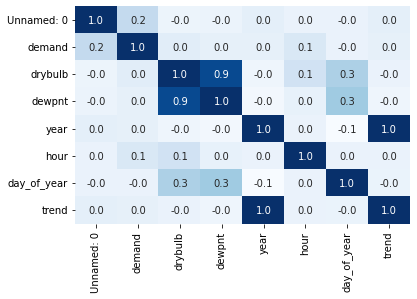

In [13]:
sns.heatmap(df.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

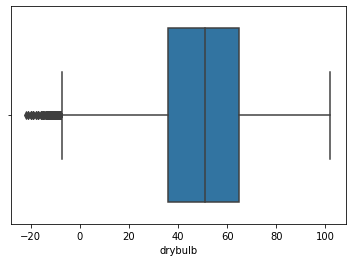

In [14]:
sns.boxplot(df['drybulb'])

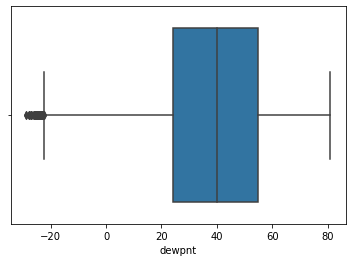

In [15]:
sns.boxplot(df['dewpnt'])

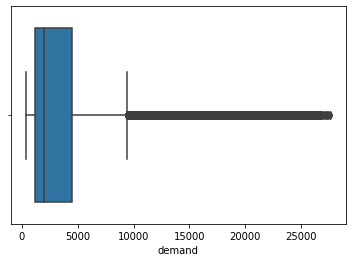

In [16]:
sns.boxplot(df['demand'])

In [17]:
df = df.set_index('ts')

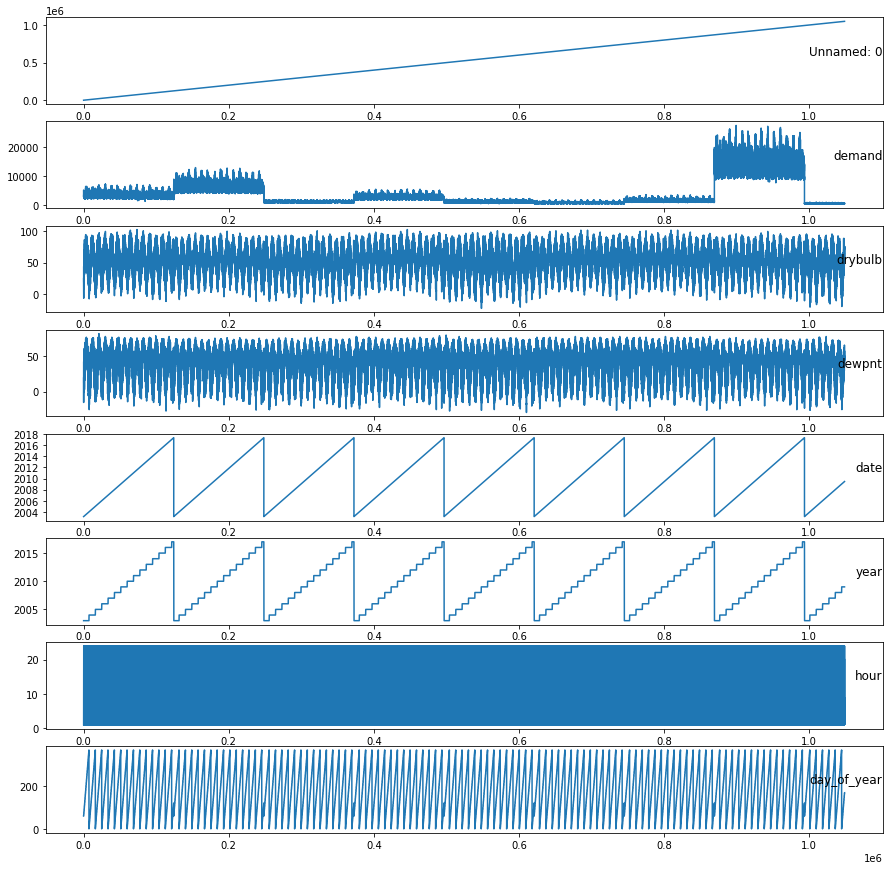

In [18]:
from matplotlib import pyplot
# load dataset
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3,4, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(15,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [19]:
df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048575 entries, nan to 6/17/2009 19:00
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Unnamed: 0   1048575 non-null  int64         
 1   demand       1048575 non-null  float64       
 2   drybulb      1048575 non-null  float64       
 3   dewpnt       1048575 non-null  float64       
 4   date         1048575 non-null  datetime64[ns]
 5   year         1048575 non-null  int64         
 6   hour         1048575 non-null  int64         
 7   day_of_year  1048575 non-null  int64         
 8   trend        1048575 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 80.0+ MB


In [20]:
10485758*0.7

7340030.6

In [21]:
train_df,test_df = df[1:7340030], df[734002:]

In [22]:
train_df.shape

(1048574, 9)

In [23]:
test_df.shape

(314573, 9)

**Optimization using pso**

In [24]:
print(f'Number of rows: {train_df.shape[0]};  Number of columns: {train_df.shape[1]}; No of missing values: {sum(train_df.isna().sum())}')

Number of rows: 1048574;  Number of columns: 9; No of missing values: 0


In [25]:
train_df.dtypes

Unnamed: 0              int64
demand                float64
drybulb               float64
dewpnt                float64
date           datetime64[ns]
year                    int64
hour                    int64
day_of_year             int64
trend                 float64
dtype: object

In [26]:
train_df.describe()

,Unnamed: 0,demand,drybulb,dewpnt,year,hour,day_of_year,trend
count,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06,1.048574e+06
mean,5.242885e+05,3.957456e+03,5.019708e+01,3.867814e+01,2.009542e+03,1.250243e+01,1.816918e+02,6.028363e+04
std,3.026974e+05,4.423006e+03,1.870094e+01,1.969047e+01,4.109257e+00,6.921117e+00,1.051945e+02,3.592336e+04
min,2.000000e+00,3.650000e+02,-2.200000e+01,-2.900000e+01,2.003000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.621452e+05,1.214000e+03,3.600000e+01,2.400000e+01,2.006000e+03,7.000000e+00,9.000000e+01,2.913400e+04
50%,5.242885e+05,1.963000e+03,5.100000e+01,4.000000e+01,2.009000e+03,1.300000e+01,1.800000e+02,5.864900e+04
75%,7.864318e+05,4.498000e+03,6.500000e+01,5.500000e+01,2.013000e+03,1.900000e+01,2.730000e+02,9.142375e+04
max,1.048575e+06,2.762200e+04,1.020000e+02,8.100000e+01,2.017000e+03,2.400000e+01,3.650000e+02,1.241990e+05


In [27]:
test_df.head()

,Unnamed: 0,demand,drybulb,dewpnt,date,year,hour,day_of_year,trend
ts,,,,,,,,,
1/27/2016 13:00,734003,964.716,44.0,25.0,2016-01-27,2016,14,27,113173.0
1/27/2016 14:00,734004,953.690,46.0,23.0,2016-01-27,2016,15,27,113174.0
1/27/2016 15:00,734005,948.637,47.0,21.0,2016-01-27,2016,16,27,113175.0
1/27/2016 16:00,734006,985.243,45.0,20.0,2016-01-27,2016,17,27,113176.0
1/27/2016 17:00,734007,1071.651,43.0,20.0,2016-01-27,2016,18,27,113177.0


In [28]:
print(f'Number of rows: {test_df.shape[0]};  Number of columns: {test_df.shape[1]}; No of missing values: {sum(test_df.isna().sum())}')

Number of rows: 314573;  Number of columns: 9; No of missing values: 0


In [29]:
test_df.dtypes

Unnamed: 0              int64
demand                float64
drybulb               float64
dewpnt                float64
date           datetime64[ns]
year                    int64
hour                    int64
day_of_year             int64
trend                 float64
dtype: object

In [30]:
X_train = train_df.drop(['date','drybulb'], axis=1).values
y_train = train_df['year'].values

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [33]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (1048574, 7)
Shape of y_train: (1048574,)


In [34]:
# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    fold = opts['fold']
    xt = fold['xt']
    yt = fold['yt']
    xv = fold['xv']
    yv = fold['yv']
    # number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain = xt[:, x == 1]
    ytrain = yt.reshape(num_train)
    xvalid = xv[:, x == 1]
    yvalid = yv.reshape(num_valid)
    # Training
    mdl     = LinearRegression()
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    error   = mean_squared_error(yvalid, ypred, squared=False)
    
    return error

In [35]:
# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # parameters
    alpha = 0.99
    beta = 1 - alpha
    # original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost = alpha * error + beta * (num_feat / max_feat)
        
    return cost

In [36]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X

In [37]:
def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]
        
    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()
        
    return V, Vmax, Vmin

In [38]:
def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin

In [39]:
def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x

In [40]:
def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor
    
    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2'] 
    
    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    
    # Pre
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    while t < max_iter:
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)
        
        # Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]
        
        # Store result
        curve[0,t] = fitG.copy()
        print("Iteration:", t + 1)
        print("Best (PSO):", curve[0,t])
        t += 1
        
        for i in range(N):
            for d in range(dim):
                # Update velocity
                r1     = rand()
                r2     = rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d]) 
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
    
                
    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return pso_data

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size=0.3, shuffle=True)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

In [42]:
c1  = 2         # cognitive factor
c2  = 2         # social factor 
w   = 0.9       # inertia weight
k     = 5     # k-value
N     = 20    # number of pipeline
T     = 100   # maximum number of iterations
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

In [43]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [44]:
def split_series(series, n_past, n_future):
  
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [45]:
n_past = 14
n_future = 4 
n_features = 9

In [46]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [47]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

In [48]:
def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(
        hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'))

In [49]:
def build_model(embed_size, seq_len=107, pred_len=68, dropout=0.5, 
                sp_dropout=0.2, embed_dim=200, hidden_dim=256, n_layers=3):
    inputs = L.Input(shape=(seq_len, 3))
    embed = L.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
    
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3])
    )
    hidden = L.SpatialDropout1D(sp_dropout)(reshaped)
    
    for x in range(n_layers):
        hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    # Since we are only making predictions on the first part of each sequence, 
    # we have to truncate it
    truncated = hidden[:, :pred_len]
    out = L.Dense(5, activation='linear')(truncated)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(tf.optimizers.Adam(), loss=MCRMSE)
    
    return model
    

In [50]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14, 9)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        44000       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 4, 100)       0           ['lstm[0][0]']                   
                                                                                              

In [51]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 14, 9)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 14, 100),    44000       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_3 (LSTM)                  [(None, 100),        80400       ['lstm_2[0][0]']                 
                                 (None, 100),                                               

In [52]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test),batch_size=64,verbose=0,callbacks=[reduce_lr])


In [53]:
#model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
#history_e2d2=model_e2d2.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test),batch_size=64,verbose=0,callbacks=[reduce_lr])

In [54]:
pred_e1d1=model_e1d1.predict(X_test)
#pred_e2d2=model_e2d2.predict(X_test)

9830/9830 [==============================] - 65s 7ms/step


In [55]:
# evaluate the model
X_train = model_e1d1.evaluate(X_train, y_train, verbose=0)
X_test = model_e1d1.evaluate(X_test, y_test, verbose=0)

In [ ]:
# evaluate the model
#X_train = model_e2d2.evaluate(X_train, y_train, verbose=0)
#X_test = model_e2d2.evaluate(X_test, y_test, verbose=0)

In [56]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    #pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [58]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,5):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    #print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

Unnamed: 0
Day  1 :
MAE-E1D1 :  1321.3333124705935, Day  2 :
MAE-E1D1 :  1245.4587515815945, Day  3 :
MAE-E1D1 :  1201.6818308981549, Day  4 :
MAE-E1D1 :  1162.3234894978955, 

demand
Day  1 :
MAE-E1D1 :  24.607054865029426, Day  2 :
MAE-E1D1 :  24.315692076319017, Day  3 :
MAE-E1D1 :  25.813094521583984, Day  4 :
MAE-E1D1 :  26.69116097498413, 

drybulb
Day  1 :
MAE-E1D1 :  0.3334051466331993, Day  2 :
MAE-E1D1 :  0.3137365232780103, Day  3 :
MAE-E1D1 :  0.3324186329827282, Day  4 :
MAE-E1D1 :  0.3081551810655195, 

dewpnt
Day  1 :
MAE-E1D1 :  0.13463633468900485, Day  2 :
MAE-E1D1 :  0.12963812813827763, Day  3 :
MAE-E1D1 :  0.1384340849221798, Day  4 :
MAE-E1D1 :  0.1332153919831978, 

date
Day  1 :
MAE-E1D1 :  198186419831636.9, Day  2 :
MAE-E1D1 :  170033872280415.4, Day  3 :
MAE-E1D1 :  169811729799857.47, Day  4 :
MAE-E1D1 :  208595237178251.4, 

year
Day  1 :
MAE-E1D1 :  0.005610543363115159, Day  2 :
MAE-E1D1 :  0.005877285677700179, Day  3 :
MAE-E1D1 :  0.005821516267674149, 

In [59]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

In [60]:
def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(
        hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'))

In [61]:
def build_model(embed_size, seq_len=107, pred_len=68, dropout=0.5, 
                sp_dropout=0.2, embed_dim=200, hidden_dim=256, n_layers=3):
    inputs = L.Input(shape=(seq_len, 3))
    embed = L.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
    
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3])
    )
    hidden = L.SpatialDropout1D(sp_dropout)(reshaped)
    
    for x in range(n_layers):
        hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    # Since we are only making predictions on the first part of each sequence, 
    # we have to truncate it
    truncated = hidden[:, :pred_len]
    out = L.Dense(5, activation='linear')(truncated)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    model.compile(tf.optimizers.Adam(), loss=MCRMSE)
    
    return model

In [62]:
y_pred = (model_e1d1.predict(y_test) >= 0.5).astype("int")

9830/9830 [==============================] - 44s 4ms/step


In [63]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
#validation_x = np.asarray(validation_x)
#validation_y = np.asarray(validation_y)

In [66]:
model_e1d1.evaluate(X_test, y_pred)

**All of your work as per say you, have done **